In [45]:
import numpy as np
import pandas as pd
from optimization import compute_dists, compute_full_l2_dists
from data import load_data, to_relative
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# Tasks Analysis

In [2]:
coords = np.load('results/optim_params.npy')
n_dimensions = 5
n_cols = 92
vec_coords = np.reshape(coords, (-1, n_dimensions))
cols = vec_coords[:n_cols]
rows = vec_coords[n_cols:]

cols.shape, rows.shape

((92, 5), (45, 5))

In [3]:
dists = compute_dists(coords, n_cols, n_dimensions)
dists.shape

(45, 92)

In [4]:
data = load_data()
data.shape

(45, 92)

In [5]:
# create a df that is the same as the original data, but with the distances as the values
df = pd.DataFrame(dists, index=data.index, columns=data.columns)
df.head()

,Dyna.-Pla test mIoU,Dyna.-Pla val mIoU,Dyna.-S2 seg val mIoU,Dyna.-S2 seg test mIoU,OSCD f1,Dyna.-S2 CD test SCS,Dyna.-S2 CD val SCS,LEVIR-CD f1,fMoW-S2 top1acc 100%,BEN-S2 mAP,...,DOTA-V1.0 0.5% mAP50,DOTA-V1.0 1% mAP50,DOTA-V1.0 5% mAP50,DOTA-V2.0 mAP,LoveDA mIoU,HRCS2016 mAP,CDD f1,NWPUVHR-10 10% top1acc,DSFIN f1,WHU Aerial mIoU
GeoKR,0.901515,1.000000,0.763951,1.000000,0.927189,1.000000,0.614668,0.796946,1.000000,0.804262,...,0.721638,0.610873,0.543489,0.938434,0.700777,0.717636,0.764125,0.675358,1.000000,0.604119
ResNet50 IN,0.811201,0.821276,0.565472,0.806374,0.659383,0.746100,0.426361,0.517579,0.803462,0.508340,...,0.306461,0.273334,0.207032,0.811591,0.480727,0.390104,0.597608,0.325440,0.746626,0.495049
MoCo,1.000000,1.000000,0.847499,1.000000,0.941130,1.000000,0.727069,0.819247,1.000000,0.799103,...,0.496530,0.449925,0.428812,1.000000,0.800735,0.709619,0.923552,0.526429,1.000000,0.795787
SimCLR,0.999068,0.816489,0.663179,0.888370,0.786292,0.820685,0.659478,0.681034,0.938353,0.583328,...,0.348347,0.145455,0.210009,1.000000,0.707276,0.561227,0.673625,0.565618,0.865965,0.709786
BYOL,0.539435,0.828860,0.616622,0.981978,0.680563,0.748163,0.596284,0.618706,0.939796,0.658873,...,0.916886,0.900065,0.852778,0.506356,0.559618,0.647417,0.477384,0.859010,0.778363,0.530496


In [15]:
tasks_info = pd.read_csv('tasks.csv', index_col=0)
tasks_info.head()

,task
Dataset,
Dyna.-Pla,segmentation
Dyna.-S2 seg,segmentation
BEN-MM,classification
PASTIS-MM,segmentation
PASTIS-HD classif,classification


In [7]:
tasks_info["task"]['OSCD']

'change detection'

In [17]:
def find_parent_task(task):
    for t in tasks_info.index:
        if task.startswith(t):
            return t
    return None

In [18]:
task_types = [tasks_info['task'][find_parent_task(task)] for task in data.columns]

In [19]:
reducer = umap.UMAP(metric="precomputed", n_neighbors=100, min_dist=0)
dists = compute_full_l2_dists(coords, n_dimensions)
optim_coords = reducer.fit_transform(dists)

/home/adorni/Documents/mds/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/adorni/Documents/mds/venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


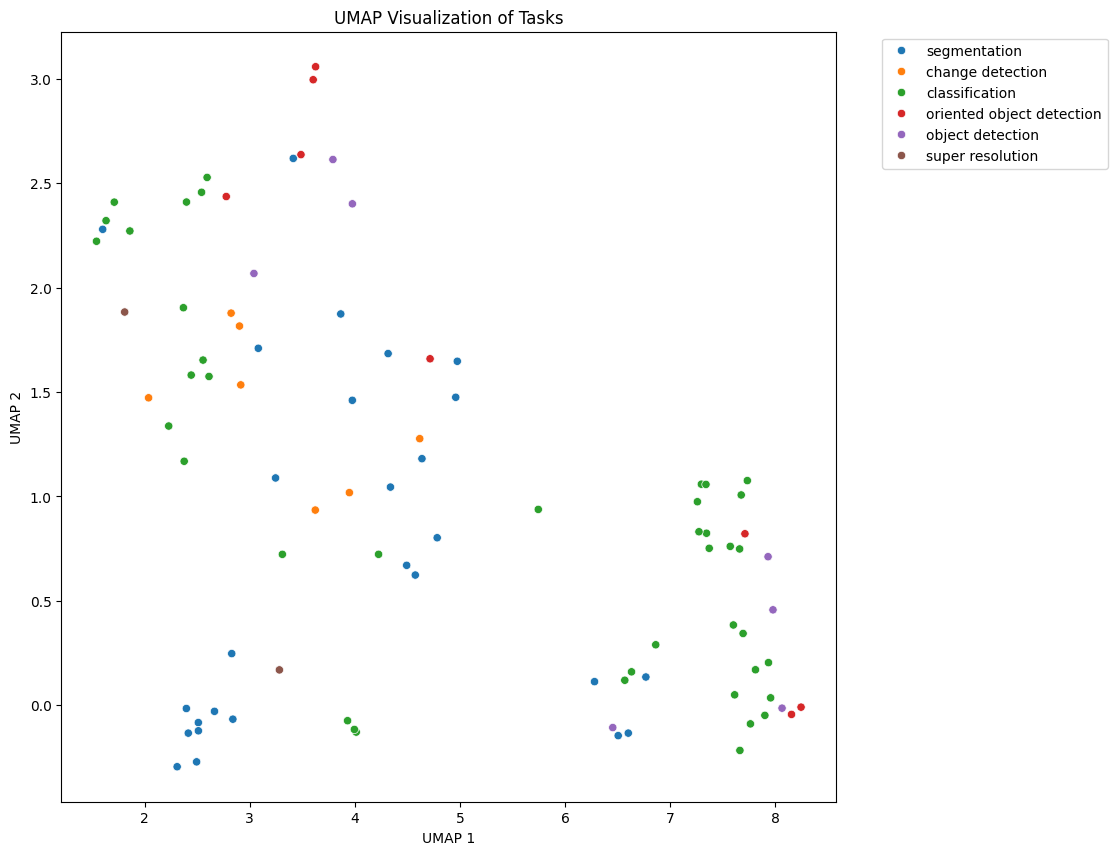

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

# parent_task_to_children = {}
# for child in data.columns:
#     parent = find_parent_task(child)
#     if parent not in parent_task_to_children:
#         parent_task_to_children[parent] = []
#     parent_task_to_children[parent].append(child)

# for parent, children in parent_task_to_children.items():
#     idx = [data.columns.get_loc(c) for c in children]
#     sns.scatterplot(x=optim_coords[idx, 0], y=optim_coords[idx, 1], ax=ax)
# plt.show()

# create a scatter plot with hue being the task type
sns.scatterplot(x=optim_coords[:n_cols, 0], y=optim_coords[:n_cols, 1], hue=task_types, ax=ax)

# improve the plot appearance
plt.title('UMAP Visualization of Tasks')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

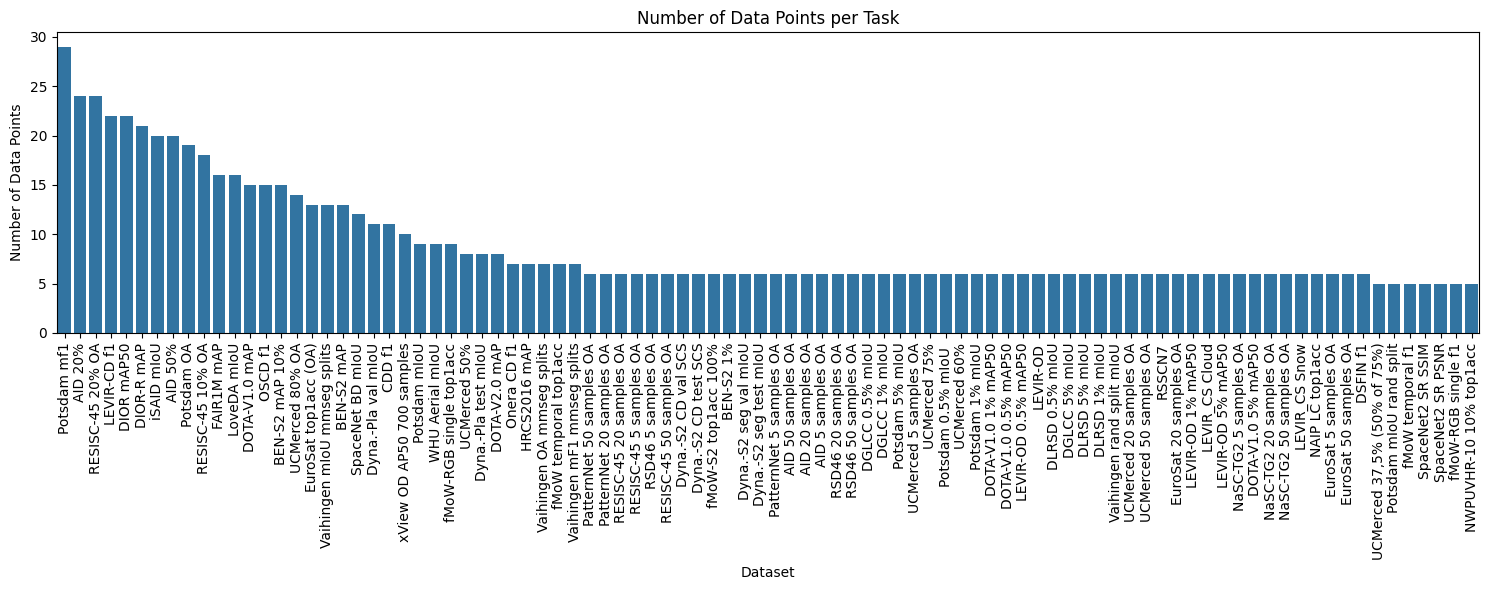

In [115]:
# sort data by count
data = data.reindex(data.count().sort_values(ascending=False).index, axis=1)
plt.figure(figsize=(15, 6))
sns.barplot(x=data.columns, y=data.count())
plt.xticks(rotation=90)
plt.xlabel('Dataset')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points per Task')
plt.tight_layout()
plt.show()

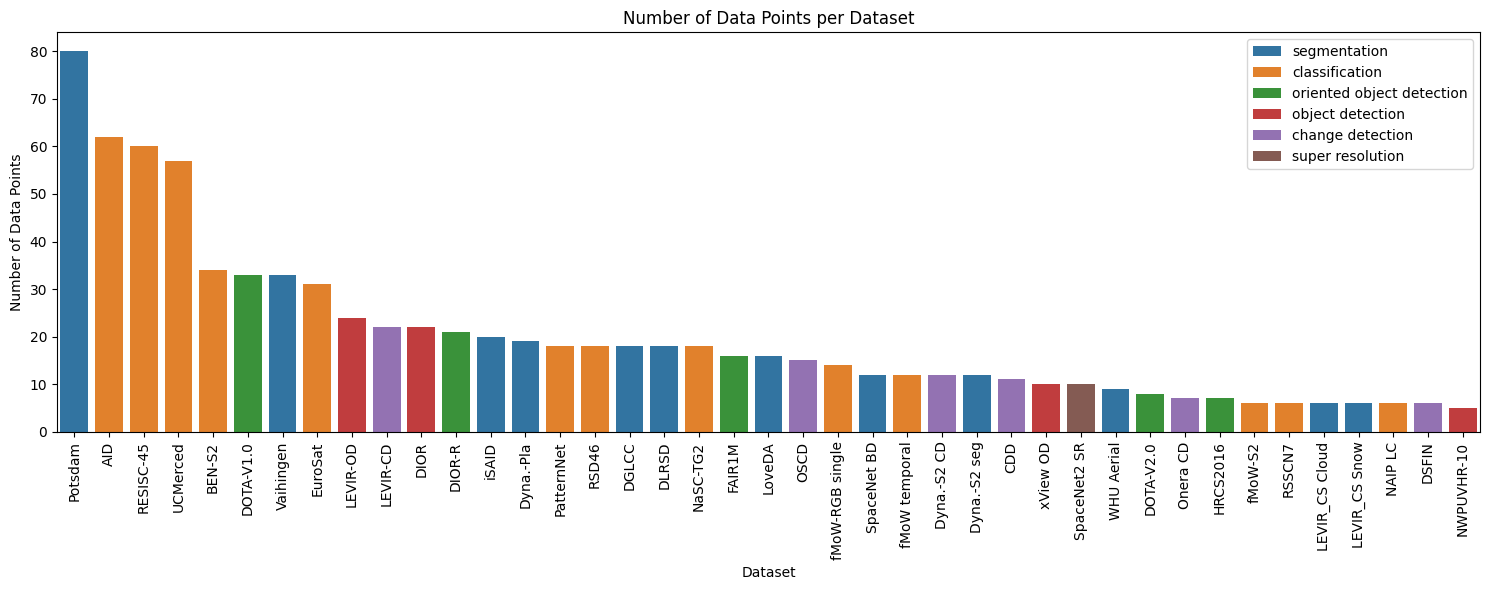

In [120]:
# same but group by parent task
parent_task_to_children = {}
for child in data.columns:
    parent = find_parent_task(child)
    if parent not in parent_task_to_children:
        parent_task_to_children[parent] = []
    parent_task_to_children[parent].append(child)

parent_task_to_count = {parent: sum(data[child].count() for child in children) for parent, children in parent_task_to_children.items()}
parent_task_to_count = {k: v for k, v in sorted(parent_task_to_count.items(), key=lambda item: item[1], reverse=True)}

parent_task_types = [tasks_info['task'][parent] for parent in parent_task_to_count.keys()]

plt.figure(figsize=(15, 6))
sns.barplot(x=list(parent_task_to_count.keys()), y=list(parent_task_to_count.values()), hue=parent_task_types)
plt.xticks(rotation=90)
plt.xlabel('Dataset')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points per Dataset')
plt.tight_layout()
plt.show()

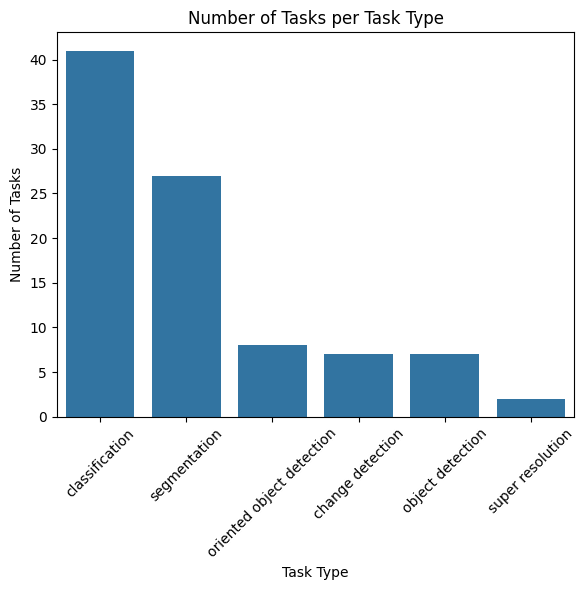

In [127]:
# same but per task type
task_type_to_count = {}
for task_type in task_types:
    if task_type not in task_type_to_count:
        task_type_to_count[task_type] = 0
    task_type_to_count[task_type] += 1

task_type_to_count = {k: v for k, v in sorted(task_type_to_count.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(6, 6))
sns.barplot(x=list(task_type_to_count.keys()), y=list(task_type_to_count.values()))
plt.xticks(rotation=45)
plt.xlabel('Task Type')
plt.ylabel('Number of Tasks')
plt.title('Number of Tasks per Task Type')
plt.tight_layout()
plt.show()

# Models analysis

In [104]:
models_info = pd.read_csv('data/models.csv', index_col=0)
models_info.head()

,Architecture,Parameters (M),Publication Date
Model,,,
GeoKR,ResNet50,24.0,05/10/2021
ResNet50 IN,ResNet50,24.0,NaN
ResNet18 IN,ResNet18,11.0,NaN
WRN-50-2 IN,WRN-50-2,68.9,NaN
MoCo,ResNet50,24.0,13/11/2019


In [105]:
# set "Publication Date" column to datetime
models_info["Publication Date"] = pd.to_datetime(models_info["Publication Date"], format='%d/%m/%Y')
# if the publication date is NaN, set it to be the minimum date
models_info['Publication Date'] = models_info['Publication Date'].fillna(models_info['Publication Date'].min())
models_info.head()

,Architecture,Parameters (M),Publication Date
Model,,,
GeoKR,ResNet50,24.0,2021-10-05
ResNet50 IN,ResNet50,24.0,2019-11-13
ResNet18 IN,ResNet18,11.0,2019-11-13
WRN-50-2 IN,WRN-50-2,68.9,2019-11-13
MoCo,ResNet50,24.0,2019-11-13


In [106]:
# Compute mean distance for each model (row)
mean_distances = df.mean(axis=1)

# Add mean distances to models_info
models_info['Mean Distance'] = mean_distances

# remove the models that have NaN values
# models_info = models_info.dropna()

# Display result
print(models_info.head())

            Architecture  Parameters (M) Publication Date  Mean Distance
Model                                                                   
GeoKR           ResNet50            24.0       2021-10-05       0.698893
ResNet50 IN     ResNet50            24.0       2019-11-13       0.487643
ResNet18 IN     ResNet18            11.0       2019-11-13            NaN
WRN-50-2 IN     WRN-50-2            68.9       2019-11-13            NaN
MoCo            ResNet50            24.0       2019-11-13       0.739838


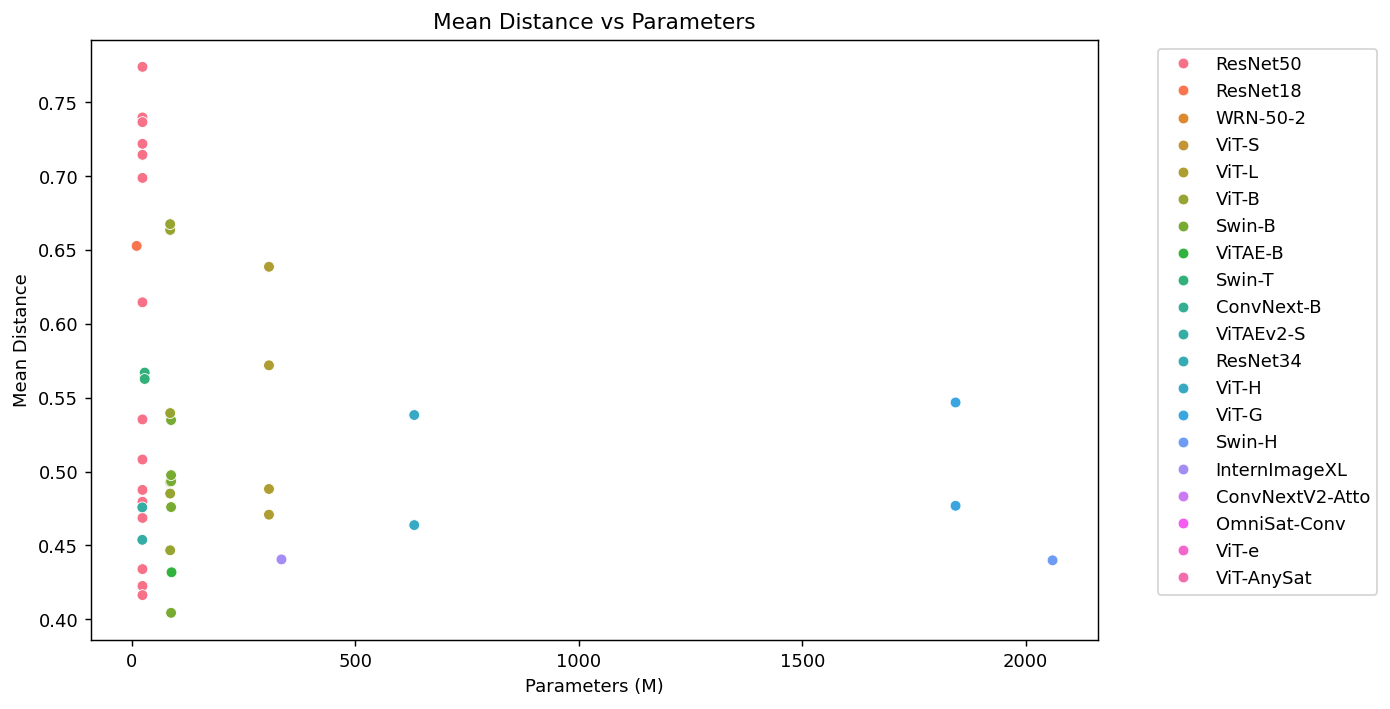

In [107]:
plt.figure(figsize=(10, 6), dpi=130)
sns.scatterplot(data=models_info, x='Parameters (M)', y='Mean Distance', hue='Architecture')
plt.title('Mean Distance vs Parameters')
# legend is outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [108]:
gt_data = load_data()
# convert the data to relative (the function returns a np array so only set the values of the df)
gt_data.values[:] = to_relative(gt_data.values)
gt_data.head()

,Dyna.-Pla test mIoU,Dyna.-Pla val mIoU,Dyna.-S2 seg val mIoU,Dyna.-S2 seg test mIoU,OSCD f1,Dyna.-S2 CD test SCS,Dyna.-S2 CD val SCS,LEVIR-CD f1,fMoW-S2 top1acc 100%,BEN-S2 mAP,...,DOTA-V1.0 0.5% mAP50,DOTA-V1.0 1% mAP50,DOTA-V1.0 5% mAP50,DOTA-V2.0 mAP,LoveDA mIoU,HRCS2016 mAP,CDD f1,NWPUVHR-10 10% top1acc,DSFIN f1,WHU Aerial mIoU
GeoKR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ResNet50 IN,NaN,NaN,NaN,NaN,0.458367,NaN,NaN,0.315503,NaN,0.307385,...,0.333333,0.336134,0.142292,1.0,0.290622,0.0,0.863248,NaN,1.0,0.506791
MoCo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SimCLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.305556,0.000000,0.019763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BYOL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.346154,NaN,NaN,NaN


In [109]:
gt_data.mean(axis=1)

GeoKR                  0.079319
ResNet50 IN            0.442150
MoCo                   0.680949
SimCLR                 0.501133
BYOL                   0.669340
MoCov2                 0.406532
GSSL                   0.672041
SSL4EO                 0.412272
GASSL MoCov2-TP        0.461852
GASSL MoCov2-TP+Geo    0.397758
GASSL MoCov2           0.750092
GASSL MoCoV2-Geo       0.552866
SeCo                   0.673014
SatMAE ViT-L           0.445862
ViT-B IN               0.442358
GeCo                   0.174077
RingMo ViT             0.292998
Swin-B IN              0.410036
RVSA ViTAE-B           0.253883
Swin-T IN              0.361170
ViTAEv2-S IN           0.200627
RSP Resnet50           0.339622
RSP Swin-T             0.363632
RSP ViTAEv2-S          0.220997
CSPT ViT-B             0.386286
BFM ViT-B              0.445440
BFM ViT-L              0.280272
BFM ViT-H              0.209557
BFM ViT-G              0.137681
TOV ResNet50           0.202414
CMID ResNet50          0.164749
CMID Swi

In [110]:
architecture_types = {
    'ResNet50': 'CNN',
    'ResNet34': 'CNN',
    'ResNet18': 'CNN',
    'WRN-50-2': 'CNN',
    'ViT-S': 'Transformer',
    'ViT-B': 'Transformer',
    'ViT-L': 'Transformer',
    'ViT-H': 'Transformer',
    'ViT-G': 'Transformer',
    'ViT-e': 'Transformer',
    'Swin-T': 'Transformer',
    'Swin-S': 'Transformer',
    'Swin-B': 'Transformer',
    'Swin-L': 'Transformer',
    'Swin-H': 'Transformer',
    'ViTAE-B': 'Transformer',
    'ConvNext-B': 'CNN',
    'ViTAEv2-S': 'Transformer',
    'InternImageXL': 'CNN',
    'ConvNextV2-Atto': 'CNN',
    'OmniSat-Conv': 'CNN',
    'ViT-AnySat': 'Transformer',
}

models_info['Architecture Type'] = models_info['Architecture'].map(architecture_types)
models_info.head()

,Architecture,Parameters (M),Publication Date,Mean Distance,Architecture Type
Model,,,,,
GeoKR,ResNet50,24.0,2021-10-05,0.698893,CNN
ResNet50 IN,ResNet50,24.0,2019-11-13,0.487643,CNN
ResNet18 IN,ResNet18,11.0,2019-11-13,NaN,CNN
WRN-50-2 IN,WRN-50-2,68.9,2019-11-13,NaN,CNN
MoCo,ResNet50,24.0,2019-11-13,0.739838,CNN


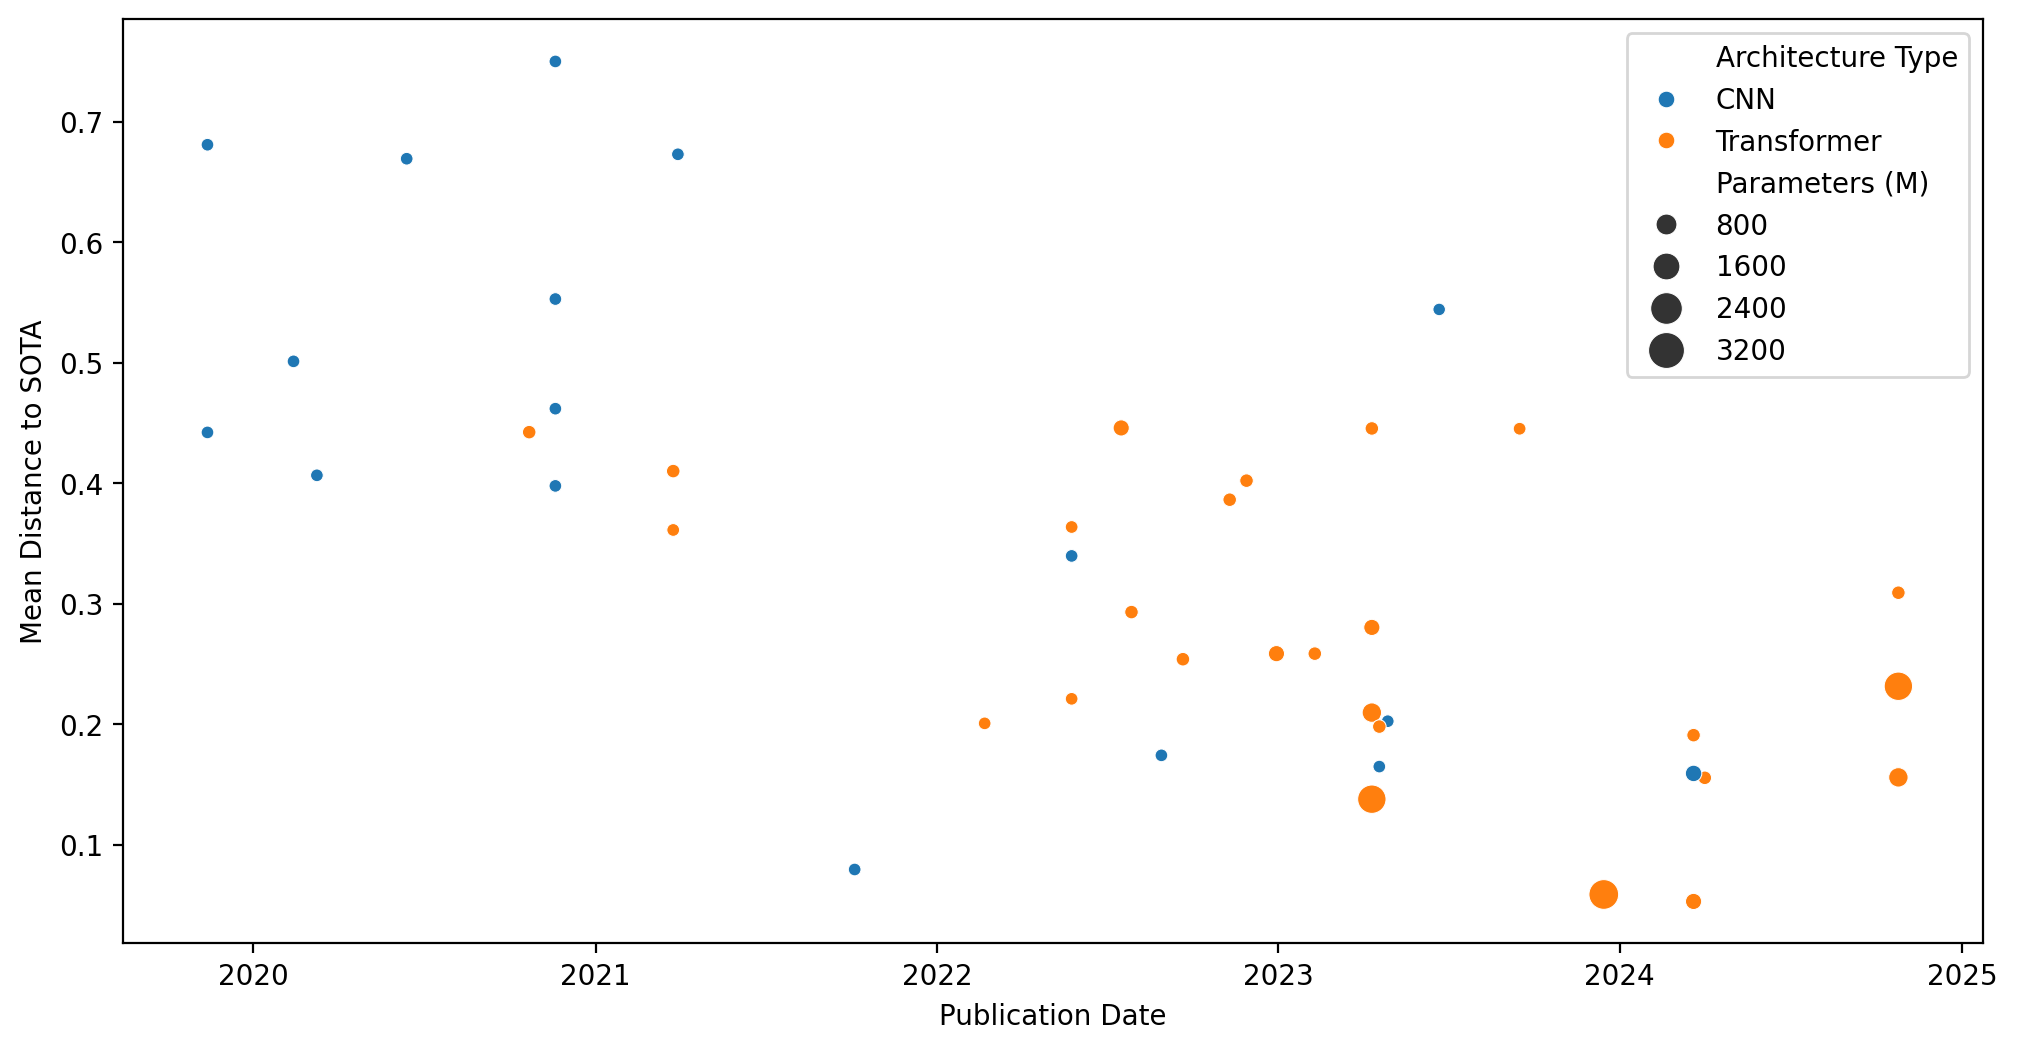

In [111]:
gt_mean_distances = gt_data.mean(axis=1)
models_info['GT Mean Distance'] = gt_mean_distances

# plot the mean distances of the ground truth data vs the publication dates, with the size of the points being the number of parameters
plt.figure(figsize=(12, 6), dpi=200)
sns.scatterplot(data=models_info, x='Publication Date', y='GT Mean Distance', hue='Architecture Type', size='Parameters (M)', sizes=(20, 200))
plt.ylabel("Mean Distance to SOTA")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()